This script is translate from @Fabienvs's [R code](https://www.kaggle.com/fabienvs/instacart-xgboost-starter-lb-0-3791), I think it may help kagglers who do not use R.  
I really appreciate @Fabienvs's great work, to be honest, I have no idea about how to handling this kind of problem(this is the first time I encounter recommendation problem- -)  
here we go!! 
below exist some very useful functions I write by my own, you can download from my [github repo](https://github.com/NickYi1990/Kaggle_Buddy.git)
sorry for adding some Chinese in it, it would not affect the code
## The dataset is too big, you should run it on your desktop!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import gc
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

aisles.csv
departments.csv
groupby_features_test.pkl
groupby_features_train.pkl
kernel38-data.pkl
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv
test_dataset.pkl
train.csv
train_dataset.pkl
zip



In [2]:
def load_data(path_data):
    '''
    --------------------------------order_product--------------------------------
    * Unique in order_id + product_id
    '''
    priors = pd.read_csv(path_data + 'order_products__prior.csv', 
                     dtype={
                            'order_id': np.int32,
                            'product_id': np.uint16,
                            'add_to_cart_order': np.int16,
                            'reordered': np.int8})
    train = pd.read_csv(path_data + 'order_products__train.csv', 
                    dtype={
                            'order_id': np.int32,
                            'product_id': np.uint16,
                            'add_to_cart_order': np.int16,
                            'reordered': np.int8})
    '''
    --------------------------------order--------------------------------
    * This file tells us which set (prior, train, test) an order belongs
    * Unique in order_id
    * order_id in train, prior, test has no intersection
    * this is the #order_number order of this user
    '''
    orders = pd.read_csv(path_data + 'orders.csv', 
                         dtype={
                                'order_id': np.int32,
                                'user_id': np.int64,
                                'eval_set': 'category',
                                'order_number': np.int16,
                                'order_dow': np.int8,
                                'order_hour_of_day': np.int8,
                                'days_since_prior_order': np.float32})

    #  order in prior, train, test has no duplicate
    #  order_ids_pri = priors.order_id.unique()
    #  order_ids_trn = train.order_id.unique()
    #  order_ids_tst = orders[orders.eval_set == 'test']['order_id'].unique()
    #  print(set(order_ids_pri).intersection(set(order_ids_trn)))
    #  print(set(order_ids_pri).intersection(set(order_ids_tst)))
    #  print(set(order_ids_trn).intersection(set(order_ids_tst)))

    '''
    --------------------------------product--------------------------------
    * Unique in product_id
    '''
    products = pd.read_csv(path_data + 'products.csv')
    aisles = pd.read_csv(path_data + "aisles.csv")
    departments = pd.read_csv(path_data + "departments.csv")
    sample_submission = pd.read_csv(path_data + "sample_submission.csv")
    
    return priors, train, orders, products, aisles, departments, sample_submission

class tick_tock:
    def __init__(self, process_name, verbose=1):
        self.process_name = process_name
        self.verbose = verbose
    def __enter__(self):
        if self.verbose:
            print(self.process_name + " begin ......")
            self.begin_time = time.time()
    def __exit__(self, type, value, traceback):
        if self.verbose:
            end_time = time.time()
            print(self.process_name + " end ......")
            print('time lapsing {0} s \n'.format(end_time - self.begin_time))
            
def ka_add_groupby_features_1_vs_n(df, group_columns_list, agg_dict, only_new_feature=True):
    '''Create statistical columns, group by [N columns] and compute stats on [N column]

       Parameters
       ----------
       df: pandas dataframe
          Features matrix
       group_columns_list: list_like
          List of columns you want to group with, could be multiple columns
       agg_dict: python dictionary

       Return
       ------
       new pandas dataframe with original columns and new added columns

       Example
       -------
       {real_column_name: {your_specified_new_column_name : method}}
       agg_dict = {'user_id':{'prod_tot_cnts':'count'},
                   'reordered':{'reorder_tot_cnts_of_this_prod':'sum'},
                   'user_buy_product_times': {'prod_order_once':lambda x: sum(x==1),
                                              'prod_order_more_than_once':lambda x: sum(x==2)}}
       ka_add_stats_features_1_vs_n(train, ['product_id'], agg_dict)
    '''
    with tick_tock("add stats features"):
        try:
            if type(group_columns_list) == list:
                pass
            else:
                raise TypeError(k + "should be a list")
        except TypeError as e:
            print(e)
            raise

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped.agg(agg_dict)
        the_stats.columns = the_stats.columns.droplevel(0)
        the_stats.reset_index(inplace=True)
        if only_new_feature:
            df_new = the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')

    return df_new

def ka_add_groupby_features_n_vs_1(df, group_columns_list, target_columns_list, methods_list, keep_only_stats=True, verbose=1):
    '''Create statistical columns, group by [N columns] and compute stats on [1 column]

       Parameters
       ----------
       df: pandas dataframe
          Features matrix
       group_columns_list: list_like
          List of columns you want to group with, could be multiple columns
       target_columns_list: list_like
          column you want to compute stats, need to be a list with only one element
       methods_list: list_like
          methods that you want to use, all methods that supported by groupby in Pandas

       Return
       ------
       new pandas dataframe with original columns and new added columns

       Example
       -------
       ka_add_stats_features_n_vs_1(train, group_columns_list=['x0'], target_columns_list=['x10'])
    '''
    with tick_tock("add stats features", verbose):
        dicts = {"group_columns_list": group_columns_list , "target_columns_list": target_columns_list, "methods_list" :methods_list}

        for k, v in dicts.items():
            try:
                if type(v) == list:
                    pass
                else:
                    raise TypeError(k + "should be a list")
            except TypeError as e:
                print(e)
                raise

        grouped_name = ''.join(group_columns_list)
        target_name = ''.join(target_columns_list)
        combine_name = [[grouped_name] + [method_name] + [target_name] for method_name in methods_list]

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped[target_name].agg(methods_list).reset_index()
        the_stats.columns = [grouped_name] + \
                            ['_%s_%s_by_%s' % (grouped_name, method_name, target_name) \
                             for (grouped_name, method_name, target_name) in combine_name]
        if keep_only_stats:
            return the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')
        return df_new

In [3]:
path_data = '../input/'
priors, train, orders, products, aisles, departments, sample_submission = load_data(path_data)

# Product part

In [4]:
# Products information ----------------------------------------------------------------
# add order information to priors set
priors_orders_detail = orders.merge(right=priors, how='inner', on='order_id')

# create new variables
# _user_buy_product_times: 用户是第几次购买该商品
priors_orders_detail.loc[:,'_user_buy_product_times'] = priors_orders_detail.groupby(['user_id', 'product_id']).cumcount() + 1
# _prod_tot_cnts: 该商品被购买的总次数,表明被喜欢的程度
# _reorder_tot_cnts_of_this_prod: 这件商品被再次购买的总次数
### 我觉得下面两个很不好理解，考虑改变++++++++++++++++++++++++++
# _prod_order_once: 该商品被购买一次的总次数
# _prod_order_more_than_once: 该商品被购买一次以上的总次数
agg_dict = {'user_id':{'_prod_tot_cnts':'count'}, 
            'reordered':{'_prod_reorder_tot_cnts':'sum'}, 
            '_user_buy_product_times': {'_prod_buy_first_time_total_cnt':lambda x: sum(x==1),
                                        '_prod_buy_second_time_total_cnt':lambda x: sum(x==2)}}
prd = ka_add_groupby_features_1_vs_n(priors_orders_detail, ['product_id'], agg_dict)

# _prod_reorder_prob: 这个指标不好理解
# _prod_reorder_ratio: 商品复购率
prd['_prod_reorder_prob'] = prd._prod_buy_second_time_total_cnt / prd._prod_buy_first_time_total_cnt
prd['_prod_reorder_ratio'] = prd._prod_reorder_tot_cnts / prd._prod_tot_cnts
prd['_prod_reorder_times'] = 1 + prd._prod_reorder_tot_cnts / prd._prod_buy_first_time_total_cnt

add stats features begin ......


/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


add stats features end ......
time lapsing 112.599025011 s 



In [5]:
prd.head()

,product_id,_prod_buy_second_time_total_cnt,_prod_buy_first_time_total_cnt,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_reorder_prob,_prod_reorder_ratio,_prod_reorder_times
0,1,276,716,1852,1136.0,0.385475,0.613391,2.586592
1,2,8,78,90,12.0,0.102564,0.133333,1.153846
2,3,36,74,277,203.0,0.486486,0.732852,3.743243
3,4,64,182,329,147.0,0.351648,0.446809,1.807692
4,5,4,6,15,9.0,0.666667,0.600000,2.500000


# User Part

In [6]:
# _user_total_orders: 用户的总订单数
# 可以考虑加入其它统计指标++++++++++++++++++++++++++
# _user_sum_days_since_prior_order: 距离上次购买时间(和),这个只能在orders表里面计算，priors_orders_detail不是在order level上面unique
# _user_mean_days_since_prior_order: 距离上次购买时间(均值)
agg_dict_2 = {'order_number':{'_user_total_orders':'max'},
              'days_since_prior_order':{'_user_sum_days_since_prior_order':'sum', 
                                        '_user_mean_days_since_prior_order': 'mean'}}
users = ka_add_groupby_features_1_vs_n(orders[orders.eval_set == 'prior'], ['user_id'], agg_dict_2)

# _user_reorder_ratio: reorder的总次数 / 第一单后买后的总次数
# _user_total_products: 用户购买的总商品数
# _user_distinct_products: 用户购买的unique商品数
agg_dict_3 = {'reordered':
              {'_user_reorder_ratio': 
               lambda x: sum(priors_orders_detail.ix[x.index,'reordered']==1)/
                         sum(priors_orders_detail.ix[x.index,'order_number'] > 1)},
              'product_id':{'_user_total_products':'count', 
                            '_user_distinct_products': lambda x: x.nunique()}}
us = ka_add_groupby_features_1_vs_n(priors_orders_detail, ['user_id'], agg_dict_3)
users = users.merge(us, how='inner')

# 平均每单的商品数
# 每单中最多的商品数，最少的商品数++++++++++++++
users['_user_average_basket'] = users._user_total_products / users._user_total_orders

us = orders[orders.eval_set != "prior"][['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
us.rename(index=str, columns={'days_since_prior_order': 'time_since_last_order'}, inplace=True)

users = users.merge(us, how='inner')

add stats features begin ......
add stats features end ......
time lapsing 0.337326049805 s 

add stats features begin ......


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


add stats features end ......
time lapsing 896.415863037 s 



In [7]:
users.head()

,user_id,_user_mean_days_since_prior_order,_user_sum_days_since_prior_order,_user_total_orders,_user_total_products,_user_distinct_products,_user_reorder_ratio,_user_average_basket,order_id,eval_set,time_since_last_order
0,1,19.555555,176.0,10,59,18,0,5.900000,1187899,train,14.0
1,2,15.230769,198.0,14,195,102,0,13.928571,1492625,train,30.0
2,3,12.090909,133.0,12,88,33,0,7.333333,2774568,test,11.0
3,4,13.750000,55.0,5,18,17,0,3.600000,329954,test,30.0
4,5,13.333333,40.0,4,37,23,0,9.250000,2196797,train,6.0


# Database Part

In [8]:
# 这里应该还有很多变量可以被添加
# _up_order_count: 用户购买该商品的次数
# _up_first_order_number: 用户第一次购买该商品所处的订单数
# _up_last_order_number: 用户最后一次购买该商品所处的订单数
# _up_average_cart_position: 该商品被添加到购物篮中的平均位置
agg_dict_4 = {'order_number':{'_up_order_count': 'count', 
                              '_up_first_order_number': 'min', 
                              '_up_last_order_number':'max'}, 
              'add_to_cart_order':{'_up_average_cart_position': 'mean'}}

data = ka_add_groupby_features_1_vs_n(df=priors_orders_detail, 
                                                      group_columns_list=['user_id', 'product_id'], 
                                                      agg_dict=agg_dict_4)

data = data.merge(prd, how='inner', on='product_id').merge(users, how='inner', on='user_id')
# 该商品购买次数 / 总的订单数
# 最近一次购买商品 - 最后一次购买该商品
# 该商品购买次数 / 第一次购买该商品到最后一次购买商品的的订单数
data['_up_order_rate'] = data._up_order_count / data._user_total_orders
data['_up_order_since_last_order'] = data._user_total_orders - data._up_last_order_number
data['_up_order_rate_since_first_order'] = data._up_order_count / (data._user_total_orders - data._up_first_order_number + 1)

# add user_id to train set
train = train.merge(right=orders[['order_id', 'user_id']], how='left', on='order_id')
data = data.merge(train[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')

# release Memory
# del train, prd, users
# gc.collect()
# release Memory
del priors_orders_detail, orders
gc.collect()

add stats features begin ......
add stats features end ......
time lapsing 16.0249040127 s 



295

In [9]:
data.head()

,user_id,product_id,_up_average_cart_position,_up_order_count,_up_first_order_number,_up_last_order_number,_prod_buy_second_time_total_cnt,_prod_buy_first_time_total_cnt,_prod_tot_cnts,_prod_reorder_tot_cnts,...,_user_distinct_products,_user_reorder_ratio,_user_average_basket,order_id,eval_set,time_since_last_order,_up_order_rate,_up_order_since_last_order,_up_order_rate_since_first_order,reordered
0,1,196,1.400000,10,1,10,4660,8000,35791,27791.0,...,18,0,5.9,1187899,train,14.0,1.0,0,1.000000,1.0
1,1,10258,3.333333,9,2,10,308,557,1946,1389.0,...,18,0,5.9,1187899,train,14.0,0.9,0,1.000000,1.0
2,1,10326,5.000000,1,5,5,1003,1923,5526,3603.0,...,18,0,5.9,1187899,train,14.0,0.1,5,0.166667,NaN
3,1,12427,3.300000,10,1,10,889,1679,6476,4797.0,...,18,0,5.9,1187899,train,14.0,1.0,0,1.000000,NaN
4,1,13032,6.333333,3,2,10,617,1286,3751,2465.0,...,18,0,5.9,1187899,train,14.0,0.3,0,0.333333,1.0


# Create Train / Test

In [10]:
import xgboost

train = data.loc[data.eval_set == "train",:]
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
train.loc[:, 'reordered'] = train.reordered.fillna(0)

X_test = data.loc[data.eval_set == "test",:]

# subsample 让training时间更短
X_train, X_val, y_train, y_val = train_test_split(train.drop('reordered', axis=1), train.reordered,
                                                    test_size=1, random_state=42)
d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}

watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

[0]	train-logloss:0.62566
[10]	train-logloss:0.33574
[20]	train-logloss:0.26913
[30]	train-logloss:0.252108
[40]	train-logloss:0.247793
[50]	train-logloss:0.246509
[60]	train-logloss:0.245893
[70]	train-logloss:0.245442


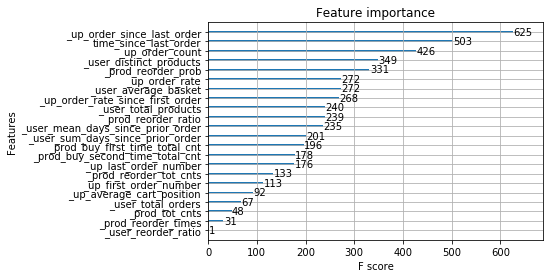

In [11]:
xgboost.plot_importance(bst)

In [12]:
d_test = xgboost.DMatrix(X_test.drop(['eval_set', 'user_id', 'order_id', 'reordered', 'product_id'], axis=1))
X_test.loc[:,'reordered'] = (bst.predict(d_test) > 0.21).astype(int)
X_test.loc[:, 'product_id'] = X_test.product_id.astype(str)
submit = ka_add_groupby_features_n_vs_1(X_test[X_test.reordered == 1], 
                                               group_columns_list=['order_id'],
                                               target_columns_list= ['product_id'],
                                               methods_list=[lambda x: ' '.join(set(x))], keep_only_stats=True)
submit.columns = sample_submission.columns.tolist()
submit_final = sample_submission[['order_id']].merge(submit, how='left').fillna('None')
submit_final.to_csv("../result/python_test.csv", index=False)

add stats features begin ......
add stats features end ......
time lapsing 1.78960490227 s 



In [13]:
sample_submission.head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


In [16]:
submit = ka_add_groupby_features_n_vs_1(X_test[X_test.reordered == 1], 
                                               group_columns_list=['order_id'],
                                               target_columns_list= ['product_id'],
                                               methods_list=[lambda x: ' '.join(set(x))], keep_only_stats=True)

submit.head()

add stats features begin ......
add stats features end ......
time lapsing 1.75967288017 s 



,order_id,_order_id_<function <lambda> at 0x7f8db7a5ede8>_by_product_id
0,17,21463 13107
1,34,2596 47792 44663 21137 39475 39180 16083 43504...
2,137,23794 2326 38689 41787 25890 24852 5134
3,182,47672 9337 47209 13629 39275 11520 33000 32109...
4,257,27104 45013 22035 24838 13870 30233 21137 3947...


In [18]:
X_test[X_test.reordered == 1].order_id

18          2161313
19          2161313
21          2161313
22          2161313
23          2161313
24          2161313
27          2161313
31          1735923
45          1735923
65          1735923
72          1735923
76          1735923
119         1735923
127         1735923
131         1735923
273          280888
356          280888
403          280888
433          280888
665          139487
672          139487
676          139487
963         3116687
965         3116687
1008        3116687
1024        3116687
1056        3116687
1109        3116687
1119        3116687
1205        3116687
             ...   
13307815    3298003
13307816    2228830
13307821     841208
13307823     841208
13307824     523318
13307843    1568556
13307848    2571126
13307850      69897
13307855    3166912
13307858     572285
13307860    3000303
13307865    2111839
13307866    2111839
13307868    2009387
13307881       7187
13307882      39315
13307892    2955768
13307900     153209
13307908    1352021
